In [181]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

In [182]:
le = LabelEncoder()

In [358]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [184]:
titles = train.Name.apply(lambda x: x.split(",", 1)[1].strip(" ")[0])
train['title'] = titles
train['title'] = le.fit_transform(train.title)

In [185]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'title'],
      dtype='object')

In [186]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)
train.drop('title', axis=1, inplace=True)

In [307]:
train['is_test'] = 0
test['is_test'] = 1
df = pd.concat([train, test])

In [308]:
df = pd.concat([df, pd.get_dummies(df['Embarked'])],axis=1)
df.drop('Embarked', axis=1, inplace=True)


In [309]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

In [310]:
df.head()

,Pclass,Age,SibSp,Parch,Fare,is_test,C,Q,S,isMale
0,3,22.0,1,0,7.2500,0,0,0,1,1
1,1,38.0,1,0,71.2833,0,1,0,0,0
2,3,26.0,0,0,7.9250,0,0,0,1,0
3,1,35.0,1,0,53.1000,0,0,0,1,0
4,3,35.0,0,0,8.0500,0,0,0,1,1


In [311]:
from sklearn.tree import DecisionTreeClassifier

In [312]:
clf = DecisionTreeClassifier(max_depth=4)

In [313]:
df.Age.fillna('Unknown', inplace=True)

In [314]:
from collections import Counter
one_big_text = " ".join(df.Age.astype(str))
words = one_big_text.replace('/',' / ').split()
most_common = Counter(words).most_common()
most_common[:20]

[('Unknown', 263),
 ('24.0', 47),
 ('22.0', 43),
 ('21.0', 41),
 ('30.0', 40),
 ('18.0', 39),
 ('25.0', 34),
 ('28.0', 32),
 ('36.0', 31),
 ('26.0', 30),
 ('27.0', 30),
 ('29.0', 30),
 ('19.0', 29),
 ('23.0', 26),
 ('32.0', 24),
 ('35.0', 23),
 ('20.0', 23),
 ('31.0', 23),
 ('45.0', 21),
 ('33.0', 21)]

In [315]:
dfAge = pd.DataFrame()
for col, num in most_common[:10]:
    a = df[~df.is_test.astype(bool)]
    dfAge[col] = a.Age.apply(lambda x: str(col) == str(x)).astype(int) 

In [316]:
clf.fit(dfAge, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [317]:
clf.feature_importances_

array([0.47003034, 0.        , 0.        , 0.25504506, 0.        ,
       0.        , 0.14457978, 0.13034482, 0.        , 0.        ])

In [318]:
dfAge.columns

Index(['Unknown', '24.0', '22.0', '21.0', '30.0', '18.0', '25.0', '28.0',
       '36.0', '26.0'],
      dtype='object')

In [319]:
df['Unknown'] = df.Age.apply(lambda x: str('Unknown') == str(x)).astype(int) 
df['21.0'] = df.Age.apply(lambda x: str('21.0') == str(x)).astype(int) 

In [320]:
df.isnull().sum()

Pclass     0
Age        0
SibSp      0
Parch      0
Fare       1
is_test    0
C          0
Q          0
S          0
isMale     0
Unknown    0
21.0       0
dtype: int64

In [321]:
df.Fare.fillna(df.Fare.median(), inplace=True)

In [336]:
def fill_unknown (x, filler):
    if str('Unknown') == str(x):
        return filler
    else:
        return x

In [338]:
df.Age = df.Age.apply(lambda x: fill_unknown(x, df.Age[df.Age!='Unknown'].median()))

In [339]:
dftrain_prep = df[~df.is_test.astype(bool)]
dftest_prep = df[df.is_test.astype(bool)]

In [340]:
from sklearn import preprocessing

In [341]:
le_y = preprocessing.LabelEncoder()

In [376]:
le = LabelEncoder()
y = le.fit_transform(y_train)
y = le_y.fit_transform(y)

In [391]:
y_train

0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [377]:
from sklearn.model_selection import GridSearchCV

In [378]:
depths = np.arange(1,10)
#features_num = np.arange(5,15)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5, return_train_score=True)

In [379]:
gridsearch.fit(dftrain_prep, y)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

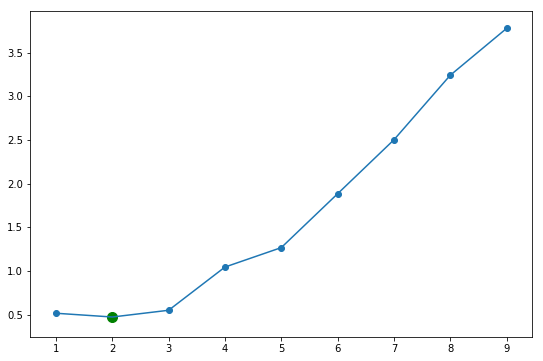

In [380]:
scores = [-x for x in gridsearch.cv_results_['mean_test_score']]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

In [381]:
clf_final = DecisionTreeClassifier(max_depth=2)

In [382]:
clf_final.fit(dftrain_prep, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [383]:
y_pred_proba = clf_final.predict_proba(dftest_prep)
y_pred = clf_final.predict(dftest_prep)

In [384]:
submit = pd.DataFrame(y_pred_proba, columns=gender_submission.columns[0:])
submit['PassengerId'] = gender_submission.PassengerId
submit = submit[[submit.columns[-1]]+list(submit.columns[:-1])]
submit.to_csv('submit_titanic.csv', index=False)

In [385]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [389]:
pd.Series(le.inverse_transform(y)).value_counts().sort_index()

0    549
1    342
dtype: int64

In [392]:
get_tree_dot_view(clf_final, list(dftrain_prep.columns), ['died', 'survived'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="isMale <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = died", fillcolor="#e5813960"] ;
1 [label="Pclass <= 2.5\ngini = 0.383\nsamples = 314\nvalue = [81, 233]\nclass = survived", fillcolor="#399de5a6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.1\nsamples = 170\nvalue = [9, 161]\nclass = survived", fillcolor="#399de5f1"] ;
1 -> 2 ;
3 [label="gini = 0.5\nsamples = 144\nvalue = [72, 72]\nclass = died", fillcolor="#e5813900"] ;
1 -> 3 ;
4 [label="Age <= 6.5\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = died", fillcolor="#e58139c4"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.444\nsamples = 24\nvalue = [8, 16]\nclass = survived", fillcolor="#399de57f"] ;
4 -> 5 ;
6 [label="gini = 0.28\nsamples = 553\nvalue = [460, 93]\nclass = died", fillcolor="#e58139cb"] ;
4 -> 6 ;
}
